# 15.1 Synthetic Control Concept

**Chapter**: 15 - Synthetic Control  
**Section**: 1 - Building a Synthetic Counterfactual  
**Facure Source**: 15-Synthetic-Control.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Problem with Aggregated Data](#11-the-problem-with-aggregated-data)
   - 1.2 [Creating a Synthetic Counterfactual](#12-creating-a-synthetic-counterfactual)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Notation and Setup](#21-notation-and-setup)
   - 2.2 [Comparison with DiD](#22-comparison-with-did)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [The California Proposition 99 Data](#31-the-california-proposition-99-data)
   - 3.2 [California vs Control States](#32-california-vs-control-states)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Synthetic control has been called "the most important innovation in policy evaluation in recent years." It's a go-to method when you have one treated unit and aggregated data. Understanding the intuition and limitations is essential.

### 1.1 The Problem with Aggregated Data

In many policy evaluations, we only have **aggregated unit-level data**:

- State-level cigarette sales (not individual purchases)
- Country-level GDP (not firm-level output)
- City-level crime rates (not individual crimes)

**Problems with traditional DiD**:

1. **Small sample size**: With 2 states × 2 periods = 4 observations, we can't do inference
2. **No perfect control**: The control state may differ systematically from the treated state
3. **Single-unit treatment**: Often only one unit is treated (California, Germany, etc.)

### 1.2 Creating a Synthetic Counterfactual

**Key insight**: We don't need to find a perfect control. We can *create* one!

$$
\text{Synthetic California} = w_1 \times \text{Nevada} + w_2 \times \text{Utah} + w_3 \times \text{Colorado} + \ldots
$$

**The synthetic control method**:

1. Find weights that make the weighted combination of control units look like the treated unit *before* treatment
2. Apply those weights to project what the treated unit *would have looked like* after treatment
3. The gap is the treatment effect

★ Insight ─────────────────────────────────────
- Synthetic control builds a "fake" treated unit from a weighted average of controls
- Pre-treatment fit validates the counterfactual
- Better pre-treatment fit → more credible post-treatment extrapolation
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Notation and Setup

**Units and time**:
- $J+1$ total units (1 treated, $J$ in donor pool)
- Unit 1 is treated; units $2, \ldots, J+1$ are controls
- $T$ time periods, with intervention at $T_0$

**Potential outcomes**:
- $Y_{1t}^N$: Outcome for unit 1 at time $t$ *without* treatment
- $Y_{1t}^I$: Outcome for unit 1 at time $t$ *with* treatment

**Treatment effect at time $t$** (for $t > T_0$):

$$
\tau_{1t} = Y_{1t}^I - Y_{1t}^N
$$

We observe $Y_{1t}^I$ (the treated outcome), but need to estimate $Y_{1t}^N$ (the counterfactual).

**Synthetic control estimator**:

$$
\hat{Y}_{1t}^N = \sum_{j=2}^{J+1} w_j Y_{jt}
$$

where $\mathbf{W} = (w_2, \ldots, w_{J+1})$ are non-negative weights that sum to 1:

$$
w_j \geq 0, \quad \sum_{j=2}^{J+1} w_j = 1
$$

### 2.2 Comparison with DiD

| Aspect | Difference-in-Differences | Synthetic Control |
|--------|--------------------------|-------------------|
| Control | Single comparison unit | Weighted combination |
| Weights | Equal (or population-weighted) | Optimized to match pre-trends |
| Validation | Parallel trends (often visual) | Pre-treatment fit (quantified) |
| Sample | Many units/individuals | Often one treated unit |
| Inference | Regression-based SEs | Permutation/placebo tests |

**Key advantage of SCM**: The pre-treatment fit provides a built-in validation check. If we can't match the treated unit pre-treatment, we know our counterfactual is unreliable.

---

## 3. Numeric Demonstration

### 3.1 The California Proposition 99 Data

**Background**: In 1988, California passed Proposition 99—a 25-cent per pack cigarette tax. We want to estimate its effect on cigarette sales.

**Data**: 39 states × 31 years (1970-2000) = 1,209 observations.

In [2]:
# Load the smoking data
cigar = load_facure_data('smoking.csv')

# Drop extra columns for simplicity
cigar = cigar.drop(columns=['lnincome', 'beer', 'age15to24'], errors='ignore')

print("=" * 60)
print("CALIFORNIA PROPOSITION 99 DATA")
print("=" * 60)
print(f"\nTotal observations: {len(cigar):,}")
print(f"Number of states: {cigar['state'].nunique()}")
print(f"Years covered: {cigar['year'].min()} - {cigar['year'].max()}")
print(f"\nTreated unit: California (state = 3)")
print(f"Treatment year: 1988 (Proposition 99)")

CALIFORNIA PROPOSITION 99 DATA

Total observations: 1,209
Number of states: 39
Years covered: 1970 - 2000

Treated unit: California (state = 3)
Treatment year: 1988 (Proposition 99)


In [3]:
# Data structure
print("\nData variables:")
for col in cigar.columns:
    print(f"  {col:20} : {cigar[col].dtype}")

print("\nCalifornia sample:")
print(cigar.query('california').head())


Data variables:
  state                : int64
  year                 : int64
  cigsale              : float64
  retprice             : float64
  california           : bool
  after_treatment      : bool

California sample:
    state  year  cigsale  retprice  california  after_treatment
62      3  1970 123.0000   38.8000        True            False
63      3  1971 121.0000   39.7000        True            False
64      3  1972 123.5000   39.9000        True            False
65      3  1973 124.4000   39.9000        True            False
66      3  1974 126.7000   41.9000        True            False


### 3.2 California vs Control States

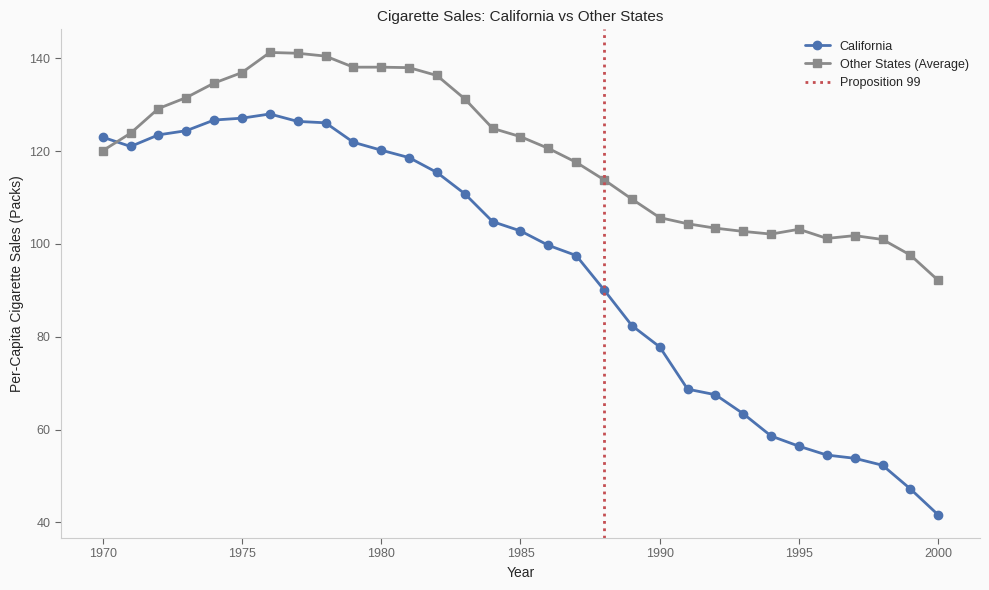

In [4]:
# Compare California to average of other states
calif = cigar.query('california')
others = cigar.query('~california').groupby('year')['cigsale'].mean().reset_index()

fig, ax = create_tufte_figure(figsize=(10, 6))

ax.plot(calif['year'], calif['cigsale'], 'o-', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=6,
        label='California')
ax.plot(others['year'], others['cigsale'], 's-', 
        color=TUFTE_PALETTE['control'], linewidth=2, markersize=6,
        label='Other States (Average)')

# Mark Proposition 99
ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2, label='Proposition 99')

ax.set_xlabel('Year')
ax.set_ylabel('Per-Capita Cigarette Sales (Packs)')
ax.set_title('Cigarette Sales: California vs Other States')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [5]:
# The problem: simple average isn't a good match
pre_treatment = cigar.query('~after_treatment')

calif_pre_mean = pre_treatment.query('california')['cigsale'].mean()
others_pre_mean = pre_treatment.query('~california')['cigsale'].mean()

print("Pre-treatment average cigarette sales:")
print(f"  California:    {calif_pre_mean:.1f} packs per capita")
print(f"  Other states:  {others_pre_mean:.1f} packs per capita")
print(f"  Difference:    {others_pre_mean - calif_pre_mean:.1f} packs")
print("\n⚠️  Other states have ~8% higher baseline sales")
print("   Using the simple average as control may bias our estimate")

Pre-treatment average cigarette sales:
  California:    116.2 packs per capita
  Other states:  130.6 packs per capita
  Difference:    14.4 packs

⚠️  Other states have ~8% higher baseline sales
   Using the simple average as control may bias our estimate


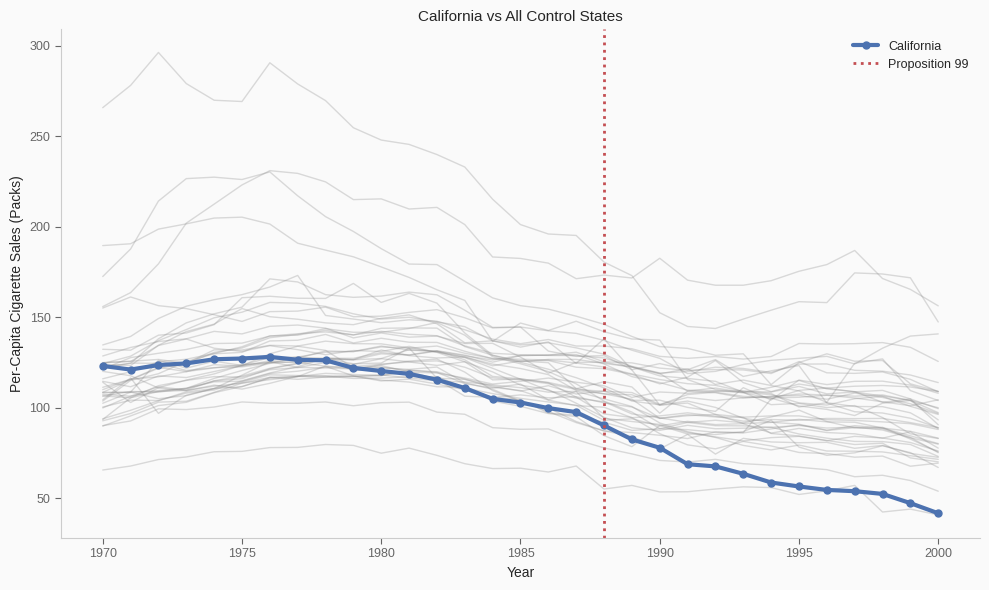

Key observation: There's huge variation among control states.
No single state perfectly matches California.
→ Solution: Create a WEIGHTED combination of states!


In [6]:
# Visualize the diversity of control states
fig, ax = create_tufte_figure(figsize=(10, 6))

# Plot each control state
for state in cigar.query('~california')['state'].unique():
    state_data = cigar.query(f'state == {state}')
    ax.plot(state_data['year'], state_data['cigsale'], 
            color=TUFTE_PALETTE['secondary'], alpha=0.3, linewidth=1)

# Highlight California
ax.plot(calif['year'], calif['cigsale'], 'o-', 
        color=TUFTE_PALETTE['treatment'], linewidth=3, markersize=5,
        label='California')

ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2, label='Proposition 99')

ax.set_xlabel('Year')
ax.set_ylabel('Per-Capita Cigarette Sales (Packs)')
ax.set_title('California vs All Control States')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("Key observation: There's huge variation among control states.")
print("No single state perfectly matches California.")
print("→ Solution: Create a WEIGHTED combination of states!")

★ Insight ─────────────────────────────────────
**The synthetic control idea:**

- No single control state matches California perfectly
- But a *weighted combination* of states might!
- Find weights to match pre-1988 trends
- Use those weights to project the counterfactual post-1988
─────────────────────────────────────────────────

---

## 4. Implementation

**Production implementation** uses constrained optimization:

```python
from scipy.optimize import fmin_slsqp
from functools import partial

def loss_w(W, X, y):
    """Pre-treatment RMSE between synthetic and treated."""
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_weights(X, y):
    """Find weights minimizing pre-treatment error."""
    w_start = [1/X.shape[1]] * X.shape[1]  # Start with equal weights
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        np.array(w_start),
        f_eqcons=lambda x: np.sum(x) - 1,  # Sum to 1
        bounds=[(0.0, 1.0)] * len(w_start), # Non-negative
        disp=False
    )
    return weights
```

The next notebook covers the optimization in detail.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"When would you use synthetic control over difference-in-differences?"*

<details>
<summary>Solution</summary>

**Use synthetic control when**:

1. **Single treated unit**: Only one state/country receives treatment (can't do standard DiD inference)

2. **Aggregated data**: You have state-level or country-level data (small N)

3. **No perfect control**: No single untreated unit matches the treated unit well

4. **Want explicit validation**: Pre-treatment fit provides built-in validation

**Use DiD when**:

1. Multiple treated and control units with individual-level data
2. Clear treatment and control groups
3. Want regression-based inference

**Key point**: They're complements, not substitutes. SCM is best for case studies with aggregated data; DiD is best for experimental or quasi-experimental designs with many units.

</details>

---

**Q2 (Google L5, Quant)**: *"What validates a synthetic control? How do you know your counterfactual is credible?"*

<details>
<summary>Solution</summary>

**Validation comes from pre-treatment fit.**

**Quantitative measures**:

1. **Pre-treatment RMSE**: 
   $$\text{RMSE}_{\text{pre}} = \sqrt{\frac{1}{T_0} \sum_{t=1}^{T_0} (Y_{1t} - \hat{Y}_{1t}^N)^2}$$
   Lower is better.

2. **Visual inspection**: Plot treated vs synthetic pre-treatment—should overlap closely.

3. **Covariate balance**: Check if synthetic matches treated on key predictors.

**If pre-treatment fit is poor**:

- Treated unit is too different from donor pool (extrapolation needed)
- Counterfactual is unreliable
- Report with caveats or reconsider method

**Key interview point**: The pre-treatment period is like a validation set. Good fit ≠ guaranteed validity post-treatment, but poor fit = likely invalid counterfactual.

</details>

---

**Q3 (Amazon L6, Econ)**: *"Why do synthetic control weights need to be non-negative and sum to one?"*

<details>
<summary>Solution</summary>

**The constraints ensure we're doing interpolation, not extrapolation.**

**Non-negative weights** ($w_j \geq 0$):
- Prevents "subtracting" a state
- The synthetic is a positive combination of real states
- Interpretable: "30% Nevada, 25% Utah, ..."

**Weights sum to 1** ($\sum w_j = 1$):
- Convex combination
- Synthetic is "inside" the range of control units
- No scaling up or down beyond observed data

**Why not unconstrained OLS?**

- With J > T (more states than time periods), OLS overfits
- Can create perfect pre-treatment fit with wildly wrong post-treatment projection
- Negative weights are uninterpretable ("-50% Texas"?)

**The convex hull constraint**:
- Synthetic must lie within the "hull" of control units
- If treated is outside this hull, it can't be perfectly matched
- This is informative: extreme treated units have worse counterfactuals

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 15: "Synthetic Control."

[^2]: Abadie, A., Diamond, A., and Hainmueller, J. (2010). Synthetic Control Methods for Comparative Case Studies. *Journal of the American Statistical Association*, 105(490), 493-505.

[^3]: Abadie, A. (2021). Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects. *Journal of Economic Literature*, 59(2), 391-425.

[^4]: Athey, S. and Imbens, G. W. (2017). The State of Applied Econometrics: Causality and Policy Evaluation. *Journal of Economic Perspectives*, 31(2), 3-32. ("most important innovation")

---

**Precision Improvement:**
- You said: "Build synthetic control intro"
- Concise: "Build 01_synthetic_concept.ipynb"
- Precise: `/augmented 15.1 --weighted-counterfactual --prop99-data`
- Pattern: [build] [target] [content-flags]